# LightGBM
### Parameters:
System:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
    * **speed** (*land speed*)
        * **other speeds**: fly, climb, swim
    * **num immunities**
    * **resistances**: fire, cold, electricity, acid, piercing, slashing, physical, bludgeoning, mental, poison, all-damage
    * **weaknesses**: cold-iron, good, fire, cold, area-damage, splash-damage, evil, slashing
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

Items
* **items**
    * **melee**
    * **ranged**
    * **spells nr**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
features = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
    "land_speed",
    "num_immunities",
    "fly",
    "swim",
    "climb",
    "fire_resistance",
    "cold_resistance",
    "electricity_resistance",
    "acid_resistance",
    "piercing_resistance",
    "slashing_resistance",
    "physical_resistance",
    "bludgeoning_resistance",
    "mental_resistance",
    "poison_resistance",
    "all-damage_resistance",
    "cold-iron_weakness",
    "good_weakness",
    "fire_weakness",
    "cold_weakness",
    "area-damage_weakness",
    "splash-damage_weakness",
    "evil_weakness",
    "slashing_weakness",
    "melee",
    "ranged",
    "spells",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=features,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 52 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   perception              1206 non-null   int64  
 1   hp                      1206 non-null   int64  
 2   fortitude               1206 non-null   int64  
 3   wis                     1206 non-null   int64  
 4   reflex                  1206 non-null   int64  
 5   str                     1206 non-null   int64  
 6   level                   1206 non-null   int64  
 7   int                     1206 non-null   int64  
 8   will                    1206 non-null   int64  
 9   focus                   1206 non-null   int32  
 10  ac                      1206 non-null   int64  
 11  num_immunities          1206 non-null   int64  
 12  land_speed              1206 non-null   float64
 13  con                     1206 non-null   int64  
 14  cha                     1206 non-null   

In [3]:
df.head()

,perception,hp,fortitude,wis,reflex,str,level,int,will,focus,...,spells_nr_lvl_4,spells_nr_lvl_5,spells_nr_lvl_6,spells_nr_lvl_7,spells_nr_lvl_8,spells_nr_lvl_9,melee_max_bonus,avg_melee_dmg,ranged_max_bonus,avg_ranged_dmg
0,20,215,22,2,19,7,10,1,17,1,...,0,0,0,0,0,0,23,22.0,0,0.0
1,16,220,21,2,14,9,10,-4,16,0,...,0,0,0,0,0,0,23,22.0,0,0.0
2,17,175,20,3,17,7,8,-4,15,0,...,0,0,0,0,0,0,21,16.0,0,0.0
3,30,315,30,5,29,7,17,6,32,1,...,1,0,1,0,0,0,33,31.5,0,0.0
4,6,20,6,1,10,-5,1,-1,4,1,...,1,0,0,0,0,0,0,0.0,8,5.0


###### Level

In [4]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [5]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [6]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


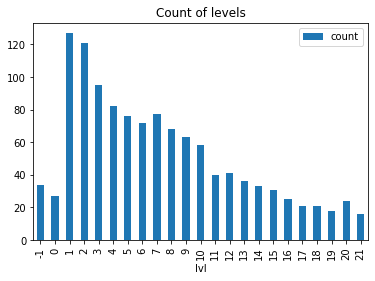

In [7]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [8]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [9]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [10]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [11]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 756
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 45
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[88]	valid_0's l1: 0.463517	valid_0's l2: 0.932502


In [13]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.93
RMSE: 0.97
MAE: 0.46


In [15]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Set of features": [],
        "MSE": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "default", "full", mse, rmse, mae]

In [16]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.13
RMSE test: 0.97


###### MAE by level

In [17]:
from training.results import plot_mae_by_level

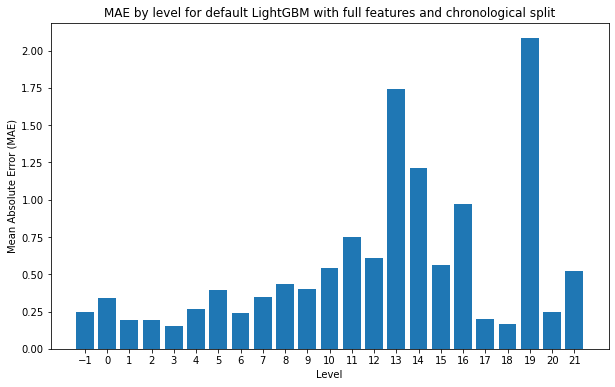

In [18]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for default LightGBM with full features and chronological split",
)

In [19]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Default:
MSE: 0.93
RMSE: 0.97

Round type: round
MSE: 0.97
RMSE: 0.98

Round type: 0.33
MSE: 0.91
RMSE: 0.96

Round type: 0.45
MSE: 0.93
RMSE: 0.96



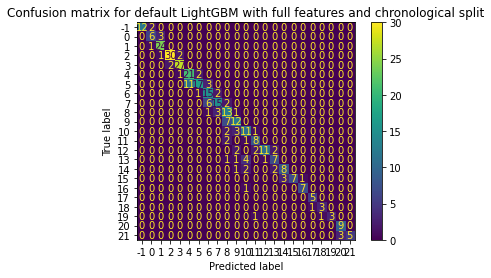

In [20]:
plot_confusion_matrix(
    "round",
    y_pred_test,
    y_test,
    title="Confusion matrix for default LightGBM with full features and chronological split",
)

#### Tuning

In [21]:
from training.results import assess_regression_model

In [22]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-05 11:54:48,103] A new study created in memory with name: no-name-79aab4f7-aaf3-4710-b685-046747e247fa
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.14125 + 0.0328303
[200]	cv_agg's l2: 0.135086 + 0.0294776
[300]	cv_agg's l2: 0.134599 + 0.0282427
[400]	cv_agg's l2: 0.134125 + 0.0280716
[500]	cv_agg's l2: 0.133852 + 0.0278969
[600]	cv_agg's l2: 0.1339 + 0.0278854


feature_fraction, val_score: 0.133790:  14%|######4                                      | 1/7 [00:11<01:10, 11.82s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.143692 + 0.0387776
[200]	cv_agg's l2: 0.140008 + 0.0375969
[300]	cv_agg's l2: 0.138884 + 0.0371942
[400]	cv_agg's l2: 0.138437 + 0.0375449
[500]	cv_agg's l2: 0.138314 + 0.0372873
[600]	cv_agg's l2: 0.138313 + 0.037222


feature_fraction, val_score: 0.133790:  29%|############8                                | 2/7 [00:21<00:52, 10.52s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.149095 + 0.0331897
[200]	cv_agg's l2: 0.147886 + 0.0337797
[300]	cv_agg's l2: 0.147072 + 0.0334326
[400]	cv_agg's l2: 0.1466 + 0.0335565
[500]	cv_agg's l2: 0.146492 + 0.0335602
[600]	cv_agg's l2: 0.146575 + 0.0334306


feature_fraction, val_score: 0.133790:  43%|###################2                         | 3/7 [00:31<00:41, 10.28s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.140542 + 0.0294113
[200]	cv_agg's l2: 0.136693 + 0.0287692
[300]	cv_agg's l2: 0.136206 + 0.0280507
[400]	cv_agg's l2: 0.135906 + 0.0274343
[500]	cv_agg's l2: 0.135821 + 0.0276344
[600]	cv_agg's l2: 0.135922 + 0.027706


feature_fraction, val_score: 0.133790:  57%|#########################7                   | 4/7 [00:40<00:29,  9.85s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.144511 + 0.0360381
[200]	cv_agg's l2: 0.140703 + 0.0333988
[300]	cv_agg's l2: 0.13973 + 0.0324964
[400]	cv_agg's l2: 0.139324 + 0.0322856
[500]	cv_agg's l2: 0.139295 + 0.032133
[600]	cv_agg's l2: 0.139324 + 0.0322055


feature_fraction, val_score: 0.133790:  71%|################################1            | 5/7 [00:50<00:19,  9.78s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.154187 + 0.0353511
[200]	cv_agg's l2: 0.151938 + 0.0355101
[300]	cv_agg's l2: 0.151854 + 0.035169
[400]	cv_agg's l2: 0.152023 + 0.0351842
[500]	cv_agg's l2: 0.15215 + 0.0354372
[600]	cv_agg's l2: 0.152183 + 0.0354283


feature_fraction, val_score: 0.133790:  86%|######################################5      | 6/7 [01:03<00:10, 10.93s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.151153 + 0.038717
[200]	cv_agg's l2: 0.148451 + 0.0378034
[300]	cv_agg's l2: 0.148206 + 0.0380943
[400]	cv_agg's l2: 0.148186 + 0.0382394
[500]	cv_agg's l2: 0.148141 + 0.0383894
[600]	cv_agg's l2: 0.148078 + 0.0382069


feature_fraction, val_score: 0.133790: 100%|#############################################| 7/7 [01:15<00:00, 10.77s/it]


Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974


num_leaves, val_score: 0.133790:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.14125 + 0.0328303
[200]	cv_agg's l2: 0.135086 + 0.0294776
[300]	cv_agg's l2: 0.134599 + 0.0282427
[400]	cv_agg's l2: 0.134125 + 0.0280716
[500]	cv_agg's l2: 0.133852 + 0.0278969
[600]	cv_agg's l2: 0.1339 + 0.0278854


num_leaves, val_score: 0.133790:   5%|##5                                               | 1/20 [00:10<03:10, 10.01s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.14125 + 0.0328303
[200]	cv_agg's l2: 0.135086 + 0.0294776
[300]	cv_agg's l2: 0.134599 + 0.0282427
[400]	cv_agg's l2: 0.134125 + 0.0280716
[500]	cv_agg's l2: 0.133852 + 0.0278969
[600]	cv_agg's l2: 0.1339 + 0.0278854


num_leaves, val_score: 0.133790:  10%|#####                                             | 2/20 [00:21<03:19, 11.07s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.14125 + 0.0328303
[200]	cv_agg's l2: 0.135086 + 0.0294776
[300]	cv_agg's l2: 0.134599 + 0.0282427
[400]	cv_agg's l2: 0.134125 + 0.0280716
[500]	cv_agg's l2: 0.133852 + 0.0278969
[600]	cv_agg's l2: 0.1339 + 0.0278854


num_leaves, val_score: 0.133790:  15%|#######5                                          | 3/20 [00:32<03:04, 10.88s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.14125 + 0.0328303
[200]	cv_agg's l2: 0.135086 + 0.0294776
[300]	cv_agg's l2: 0.134599 + 0.0282427
[400]	cv_agg's l2: 0.134125 + 0.0280716
[500]	cv_agg's l2: 0.133852 + 0.0278969
[600]	cv_agg's l2: 0.1339 + 0.0278854


num_leaves, val_score: 0.133790:  20%|##########                                        | 4/20 [00:46<03:16, 12.27s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.153428 + 0.0259427
[200]	cv_agg's l2: 0.141354 + 0.0244286
[300]	cv_agg's l2: 0.137646 + 0.024194
[400]	cv_agg's l2: 0.136021 + 0.0239868
[500]	cv_agg's l2: 0.135658 + 0.0242879
[600]	cv_agg's l2: 0.135086 + 0.0241916


num_leaves, val_score: 0.133790:  25%|############5                                     | 5/20 [00:52<02:26,  9.76s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.14125 + 0.0328303
[200]	cv_agg's l2: 0.135086 + 0.0294776
[300]	cv_agg's l2: 0.134599 + 0.0282427
[400]	cv_agg's l2: 0.134125 + 0.0280716
[500]	cv_agg's l2: 0.133852 + 0.0278969
[600]	cv_agg's l2: 0.1339 + 0.0278854


num_leaves, val_score: 0.133790:  30%|###############                                   | 6/20 [01:03<02:25, 10.37s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.14125 + 0.0328303
[200]	cv_agg's l2: 0.135086 + 0.0294776
[300]	cv_agg's l2: 0.134599 + 0.0282427
[400]	cv_agg's l2: 0.134125 + 0.0280716
[500]	cv_agg's l2: 0.133852 + 0.0278969
[600]	cv_agg's l2: 0.1339 + 0.0278854


num_leaves, val_score: 0.133790:  35%|#################5                                | 7/20 [01:13<02:11, 10.11s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.14125 + 0.0328303
[200]	cv_agg's l2: 0.135086 + 0.0294776
[300]	cv_agg's l2: 0.134599 + 0.0282427
[400]	cv_agg's l2: 0.134125 + 0.0280716
[500]	cv_agg's l2: 0.133852 + 0.0278969
[600]	cv_agg's l2: 0.1339 + 0.0278854


num_leaves, val_score: 0.133790:  40%|####################                              | 8/20 [01:25<02:09, 10.77s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.14125 + 0.0328303
[200]	cv_agg's l2: 0.135086 + 0.0294776
[300]	cv_agg's l2: 0.134599 + 0.0282427
[400]	cv_agg's l2: 0.134125 + 0.0280716
[500]	cv_agg's l2: 0.133852 + 0.0278969
[600]	cv_agg's l2: 0.1339 + 0.0278854


num_leaves, val_score: 0.133790:  45%|######################5                           | 9/20 [01:36<01:58, 10.78s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.14125 + 0.0328303
[200]	cv_agg's l2: 0.135086 + 0.0294776
[300]	cv_agg's l2: 0.134599 + 0.0282427
[400]	cv_agg's l2: 0.134125 + 0.0280716
[500]	cv_agg's l2: 0.133852 + 0.0278969
[600]	cv_agg's l2: 0.1339 + 0.0278854


num_leaves, val_score: 0.133790:  50%|########################5                        | 10/20 [01:46<01:47, 10.73s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.14125 + 0.0328303
[200]	cv_agg's l2: 0.135086 + 0.0294776
[300]	cv_agg's l2: 0.134599 + 0.0282427
[400]	cv_agg's l2: 0.134125 + 0.0280716
[500]	cv_agg's l2: 0.133852 + 0.0278969
[600]	cv_agg's l2: 0.1339 + 0.0278854


num_leaves, val_score: 0.133790:  55%|##########################9                      | 11/20 [01:56<01:34, 10.45s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.14125 + 0.0328303
[200]	cv_agg's l2: 0.135086 + 0.0294776
[300]	cv_agg's l2: 0.134599 + 0.0282427
[400]	cv_agg's l2: 0.134125 + 0.0280716
[500]	cv_agg's l2: 0.133852 + 0.0278969
[600]	cv_agg's l2: 0.1339 + 0.0278854


num_leaves, val_score: 0.133790:  60%|#############################4                   | 12/20 [02:06<01:22, 10.28s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.14125 + 0.0328303
[200]	cv_agg's l2: 0.135086 + 0.0294776
[300]	cv_agg's l2: 0.134599 + 0.0282427
[400]	cv_agg's l2: 0.134125 + 0.0280716
[500]	cv_agg's l2: 0.133852 + 0.0278969
[600]	cv_agg's l2: 0.1339 + 0.0278854


num_leaves, val_score: 0.133790:  65%|###############################8                 | 13/20 [02:16<01:10, 10.10s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.14125 + 0.0328303
[200]	cv_agg's l2: 0.135086 + 0.0294776
[300]	cv_agg's l2: 0.134599 + 0.0282427
[400]	cv_agg's l2: 0.134125 + 0.0280716
[500]	cv_agg's l2: 0.133852 + 0.0278969
[600]	cv_agg's l2: 0.1339 + 0.0278854


num_leaves, val_score: 0.133790:  70%|##################################3              | 14/20 [02:24<00:57,  9.51s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.14125 + 0.0328303
[200]	cv_agg's l2: 0.135086 + 0.0294776
[300]	cv_agg's l2: 0.134599 + 0.0282427
[400]	cv_agg's l2: 0.134125 + 0.0280716
[500]	cv_agg's l2: 0.133852 + 0.0278969
[600]	cv_agg's l2: 0.1339 + 0.0278854


num_leaves, val_score: 0.133790:  75%|####################################7            | 15/20 [02:33<00:47,  9.42s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.14125 + 0.0328303
[200]	cv_agg's l2: 0.135086 + 0.0294776
[300]	cv_agg's l2: 0.134599 + 0.0282427
[400]	cv_agg's l2: 0.134125 + 0.0280716
[500]	cv_agg's l2: 0.133852 + 0.0278969
[600]	cv_agg's l2: 0.1339 + 0.0278854


num_leaves, val_score: 0.133790:  80%|#######################################2         | 16/20 [02:42<00:37,  9.31s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.14125 + 0.0328303
[200]	cv_agg's l2: 0.135086 + 0.0294776
[300]	cv_agg's l2: 0.134599 + 0.0282427
[400]	cv_agg's l2: 0.134125 + 0.0280716
[500]	cv_agg's l2: 0.133852 + 0.0278969
[600]	cv_agg's l2: 0.1339 + 0.0278854


num_leaves, val_score: 0.133790:  85%|#########################################6       | 17/20 [02:52<00:28,  9.57s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.14125 + 0.0328303
[200]	cv_agg's l2: 0.135086 + 0.0294776
[300]	cv_agg's l2: 0.134599 + 0.0282427
[400]	cv_agg's l2: 0.134125 + 0.0280716
[500]	cv_agg's l2: 0.133852 + 0.0278969
[600]	cv_agg's l2: 0.1339 + 0.0278854


num_leaves, val_score: 0.133790:  90%|############################################1    | 18/20 [03:06<00:21, 10.83s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.14125 + 0.0328303
[200]	cv_agg's l2: 0.135086 + 0.0294776
[300]	cv_agg's l2: 0.134599 + 0.0282427
[400]	cv_agg's l2: 0.134125 + 0.0280716
[500]	cv_agg's l2: 0.133852 + 0.0278969
[600]	cv_agg's l2: 0.1339 + 0.0278854


num_leaves, val_score: 0.133790:  95%|##############################################5  | 19/20 [03:16<00:10, 10.62s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.14125 + 0.0328303
[200]	cv_agg's l2: 0.135086 + 0.0294776
[300]	cv_agg's l2: 0.134599 + 0.0282427
[400]	cv_agg's l2: 0.134125 + 0.0280716
[500]	cv_agg's l2: 0.133852 + 0.0278969
[600]	cv_agg's l2: 0.1339 + 0.0278854


num_leaves, val_score: 0.133790: 100%|#################################################| 20/20 [03:26<00:00, 10.32s/it]


Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974


bagging, val_score: 0.133790:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.143859 + 0.0354171
[200]	cv_agg's l2: 0.138022 + 0.0319899
[300]	cv_agg's l2: 0.136171 + 0.0307284
[400]	cv_agg's l2: 0.135812 + 0.030633
[500]	cv_agg's l2: 0.135958 + 0.0305207
[600]	cv_agg's l2: 0.135888 + 0.0303216


bagging, val_score: 0.133790:  10%|#####3                                               | 1/10 [00:09<01:24,  9.43s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.190315 + 0.0386795
[200]	cv_agg's l2: 0.175623 + 0.044099
[300]	cv_agg's l2: 0.167953 + 0.041556
[400]	cv_agg's l2: 0.16765 + 0.0411807
[500]	cv_agg's l2: 0.169872 + 0.0430123
[600]	cv_agg's l2: 0.171759 + 0.0436044


bagging, val_score: 0.133790:  20%|##########6                                          | 2/10 [00:14<00:56,  7.02s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.163375 + 0.0333464
[200]	cv_agg's l2: 0.158156 + 0.0288792
[300]	cv_agg's l2: 0.156899 + 0.0290073
[400]	cv_agg's l2: 0.155956 + 0.0289248
[500]	cv_agg's l2: 0.156628 + 0.0285778
[600]	cv_agg's l2: 0.156924 + 0.029014


bagging, val_score: 0.133790:  30%|###############9                                     | 3/10 [00:22<00:50,  7.19s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.143128 + 0.0356843
[200]	cv_agg's l2: 0.13765 + 0.0341723
[300]	cv_agg's l2: 0.135818 + 0.0330834
[400]	cv_agg's l2: 0.135109 + 0.0329075
[500]	cv_agg's l2: 0.134981 + 0.0325858
[600]	cv_agg's l2: 0.134748 + 0.0324576


bagging, val_score: 0.133790:  40%|#####################2                               | 4/10 [00:31<00:48,  8.08s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.190315 + 0.0494642
[200]	cv_agg's l2: 0.179115 + 0.0437371
[300]	cv_agg's l2: 0.179074 + 0.0454874
[400]	cv_agg's l2: 0.180828 + 0.0471339
[500]	cv_agg's l2: 0.178218 + 0.0427539
[600]	cv_agg's l2: 0.179263 + 0.0424668


bagging, val_score: 0.133790:  50%|##########################5                          | 5/10 [00:37<00:36,  7.36s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.165932 + 0.031705
[200]	cv_agg's l2: 0.159458 + 0.0311228
[300]	cv_agg's l2: 0.157935 + 0.0312392
[400]	cv_agg's l2: 0.157267 + 0.0312231
[500]	cv_agg's l2: 0.157625 + 0.0327362
[600]	cv_agg's l2: 0.157618 + 0.0321721


bagging, val_score: 0.133790:  60%|###############################8                     | 6/10 [00:45<00:30,  7.51s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.17707 + 0.040537
[200]	cv_agg's l2: 0.170301 + 0.0421441
[300]	cv_agg's l2: 0.169337 + 0.0400525
[400]	cv_agg's l2: 0.169904 + 0.0395662
[500]	cv_agg's l2: 0.170708 + 0.0430233
[600]	cv_agg's l2: 0.170989 + 0.0420657


bagging, val_score: 0.133790:  70%|#####################################                | 7/10 [00:50<00:20,  6.85s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.156878 + 0.0368166
[200]	cv_agg's l2: 0.15075 + 0.0340126
[300]	cv_agg's l2: 0.148755 + 0.033201
[400]	cv_agg's l2: 0.147527 + 0.0327008
[500]	cv_agg's l2: 0.14759 + 0.0327371
[600]	cv_agg's l2: 0.146919 + 0.0321691


bagging, val_score: 0.133790:  80%|##########################################4          | 8/10 [00:58<00:14,  7.06s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.181048 + 0.0345976
[200]	cv_agg's l2: 0.172141 + 0.0321641
[300]	cv_agg's l2: 0.168939 + 0.0317823
[400]	cv_agg's l2: 0.167219 + 0.029577
[500]	cv_agg's l2: 0.1672 + 0.0283803
[600]	cv_agg's l2: 0.167979 + 0.0287538


bagging, val_score: 0.133790:  90%|###############################################7     | 9/10 [01:04<00:06,  6.74s/it]

Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974
[100]	cv_agg's l2: 0.156151 + 0.0428061
[200]	cv_agg's l2: 0.149627 + 0.0394177
[300]	cv_agg's l2: 0.147241 + 0.038376
[400]	cv_agg's l2: 0.145736 + 0.0373381
[500]	cv_agg's l2: 0.144773 + 0.0370944
[600]	cv_agg's l2: 0.143996 + 0.0366225


bagging, val_score: 0.133790: 100%|####################################################| 10/10 [01:12<00:00,  7.23s/it]


Early stopping, best iteration is:
[559]	cv_agg's l2: 0.13379 + 0.0276974


feature_fraction_stage2, val_score: 0.133790:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.138225 + 0.0317499
[200]	cv_agg's l2: 0.133159 + 0.0314406
[300]	cv_agg's l2: 0.13252 + 0.0307808
[400]	cv_agg's l2: 0.132163 + 0.0309872


feature_fraction_stage2, val_score: 0.131994:  17%|######3                               | 1/6 [00:06<00:30,  6.15s/it]

Early stopping, best iteration is:
[378]	cv_agg's l2: 0.131994 + 0.0308173
[100]	cv_agg's l2: 0.143911 + 0.0382396
[200]	cv_agg's l2: 0.138312 + 0.0353466
[300]	cv_agg's l2: 0.137677 + 0.0342573
[400]	cv_agg's l2: 0.137737 + 0.0340126


feature_fraction_stage2, val_score: 0.131994:  33%|############6                         | 2/6 [00:12<00:24,  6.09s/it]

Early stopping, best iteration is:
[378]	cv_agg's l2: 0.131994 + 0.0308173
[100]	cv_agg's l2: 0.142237 + 0.0366285
[200]	cv_agg's l2: 0.137483 + 0.0348784
[300]	cv_agg's l2: 0.13636 + 0.0342668
[400]	cv_agg's l2: 0.136314 + 0.0341038


feature_fraction_stage2, val_score: 0.131994:  50%|###################                   | 3/6 [00:19<00:20,  6.71s/it]

Early stopping, best iteration is:
[378]	cv_agg's l2: 0.131994 + 0.0308173
[100]	cv_agg's l2: 0.142146 + 0.0347305
[200]	cv_agg's l2: 0.136571 + 0.0326451
[300]	cv_agg's l2: 0.135444 + 0.0319507
[400]	cv_agg's l2: 0.135418 + 0.0317167


feature_fraction_stage2, val_score: 0.131994:  67%|#########################3            | 4/6 [00:26<00:13,  6.71s/it]

Early stopping, best iteration is:
[378]	cv_agg's l2: 0.131994 + 0.0308173
[100]	cv_agg's l2: 0.139031 + 0.033823
[200]	cv_agg's l2: 0.132373 + 0.0303337
[300]	cv_agg's l2: 0.131019 + 0.0301801
[400]	cv_agg's l2: 0.130901 + 0.0299267
[500]	cv_agg's l2: 0.1307 + 0.0296273
[600]	cv_agg's l2: 0.130594 + 0.0294539
[700]	cv_agg's l2: 0.130497 + 0.0292434
[800]	cv_agg's l2: 0.130482 + 0.0292251


feature_fraction_stage2, val_score: 0.130432:  83%|###############################6      | 5/6 [00:37<00:08,  8.23s/it]

Early stopping, best iteration is:
[754]	cv_agg's l2: 0.130432 + 0.0291563
[100]	cv_agg's l2: 0.144693 + 0.0390884
[200]	cv_agg's l2: 0.141938 + 0.0369105
[300]	cv_agg's l2: 0.140968 + 0.0358162
[400]	cv_agg's l2: 0.140998 + 0.0356539
[500]	cv_agg's l2: 0.14073 + 0.0353169
[600]	cv_agg's l2: 0.140708 + 0.0352432
[700]	cv_agg's l2: 0.140617 + 0.0351179
[800]	cv_agg's l2: 0.140685 + 0.0349976


feature_fraction_stage2, val_score: 0.130432: 100%|######################################| 6/6 [00:48<00:00,  8.07s/it]


Early stopping, best iteration is:
[754]	cv_agg's l2: 0.130432 + 0.0291563


regularization_factors, val_score: 0.130432:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.139803 + 0.0339998
[200]	cv_agg's l2: 0.134925 + 0.0310058
[300]	cv_agg's l2: 0.134666 + 0.0307925
[400]	cv_agg's l2: 0.134495 + 0.030469
[500]	cv_agg's l2: 0.13426 + 0.0303814
[600]	cv_agg's l2: 0.134384 + 0.0303637
[700]	cv_agg's l2: 0.13427 + 0.0302756
[800]	cv_agg's l2: 0.134288 + 0.0302229


regularization_factors, val_score: 0.130432:   5%|#9                                    | 1/20 [00:10<03:24, 10.79s/it]

Early stopping, best iteration is:
[754]	cv_agg's l2: 0.130432 + 0.0291563
[100]	cv_agg's l2: 0.144178 + 0.0333865
[200]	cv_agg's l2: 0.13892 + 0.0309284
[300]	cv_agg's l2: 0.137998 + 0.0300729
[400]	cv_agg's l2: 0.137618 + 0.0297851
[500]	cv_agg's l2: 0.137419 + 0.0299135
[600]	cv_agg's l2: 0.137232 + 0.029624
[700]	cv_agg's l2: 0.137008 + 0.0293685
[800]	cv_agg's l2: 0.136965 + 0.0294007


regularization_factors, val_score: 0.130432:  10%|###8                                  | 2/20 [00:21<03:16, 10.89s/it]

Early stopping, best iteration is:
[754]	cv_agg's l2: 0.130432 + 0.0291563
[100]	cv_agg's l2: 0.155868 + 0.0357936
[200]	cv_agg's l2: 0.149774 + 0.0342313
[300]	cv_agg's l2: 0.14973 + 0.0342778
[400]	cv_agg's l2: 0.149729 + 0.0342789
[500]	cv_agg's l2: 0.149729 + 0.0342789
[600]	cv_agg's l2: 0.149729 + 0.0342789
[700]	cv_agg's l2: 0.149729 + 0.0342789


regularization_factors, val_score: 0.130432:  15%|#####7                                | 3/20 [00:26<02:17,  8.11s/it]

[800]	cv_agg's l2: 0.149729 + 0.0342789
Early stopping, best iteration is:
[754]	cv_agg's l2: 0.130432 + 0.0291563


[I 2023-11-05 12:01:57,073] Trial 45 finished with value: 0.1497294107186922 and parameters: {'lambda_l1': 1.8214576472487445, 'lambda_l2': 3.34467812778213e-08}. Best is trial 43 with value: 0.13425561313917958.
regularization_factors, val_score: 0.130432:  15%|#####7                                | 3/20 [00:26<02:17,  8.11s/it]

[100]	cv_agg's l2: 0.153281 + 0.0323024
[200]	cv_agg's l2: 0.146255 + 0.0311263
[300]	cv_agg's l2: 0.145228 + 0.0308972
[400]	cv_agg's l2: 0.145314 + 0.0309336
[500]	cv_agg's l2: 0.14544 + 0.0308622
[600]	cv_agg's l2: 0.145522 + 0.0310752
[700]	cv_agg's l2: 0.145584 + 0.030953
[800]	cv_agg's l2: 0.145653 + 0.0311099


regularization_factors, val_score: 0.130432:  20%|#######6                              | 4/20 [00:36<02:19,  8.69s/it]

Early stopping, best iteration is:
[754]	cv_agg's l2: 0.130432 + 0.0291563
[100]	cv_agg's l2: 0.2092 + 0.0317362
[200]	cv_agg's l2: 0.207693 + 0.0320311
[300]	cv_agg's l2: 0.207692 + 0.0320324
[400]	cv_agg's l2: 0.207692 + 0.0320324
[500]	cv_agg's l2: 0.207692 + 0.0320324
[600]	cv_agg's l2: 0.207692 + 0.0320324
[700]	cv_agg's l2: 0.207692 + 0.0320324


regularization_factors, val_score: 0.130432:  25%|#########5                            | 5/20 [00:38<01:33,  6.24s/it]

[800]	cv_agg's l2: 0.207692 + 0.0320324
Early stopping, best iteration is:
[754]	cv_agg's l2: 0.130432 + 0.0291563
[100]	cv_agg's l2: 0.139162 + 0.0344415
[200]	cv_agg's l2: 0.133241 + 0.0316999
[300]	cv_agg's l2: 0.131955 + 0.0302418
[400]	cv_agg's l2: 0.131449 + 0.0298328
[500]	cv_agg's l2: 0.131267 + 0.0296138
[600]	cv_agg's l2: 0.131105 + 0.0295578
[700]	cv_agg's l2: 0.131191 + 0.0294749
[800]	cv_agg's l2: 0.131268 + 0.0294182


regularization_factors, val_score: 0.130432:  30%|###########4                          | 6/20 [00:43<01:24,  6.07s/it]

Early stopping, best iteration is:
[754]	cv_agg's l2: 0.130432 + 0.0291563
[100]	cv_agg's l2: 0.138345 + 0.0332742
[200]	cv_agg's l2: 0.132722 + 0.0309521
[300]	cv_agg's l2: 0.131547 + 0.029661
[400]	cv_agg's l2: 0.131289 + 0.029396
[500]	cv_agg's l2: 0.131188 + 0.0293554
[600]	cv_agg's l2: 0.131079 + 0.0292285
[700]	cv_agg's l2: 0.131052 + 0.0291154
[800]	cv_agg's l2: 0.131207 + 0.0291621


regularization_factors, val_score: 0.130432:  35%|#############3                        | 7/20 [00:49<01:15,  5.83s/it]

Early stopping, best iteration is:
[754]	cv_agg's l2: 0.130432 + 0.0291563
[100]	cv_agg's l2: 0.138345 + 0.0332742
[200]	cv_agg's l2: 0.132584 + 0.0310468
[300]	cv_agg's l2: 0.131294 + 0.029842
[400]	cv_agg's l2: 0.131087 + 0.0295428
[500]	cv_agg's l2: 0.131075 + 0.0295232
[600]	cv_agg's l2: 0.130929 + 0.0295082
[700]	cv_agg's l2: 0.130894 + 0.0294742
[800]	cv_agg's l2: 0.130977 + 0.0294973


regularization_factors, val_score: 0.130432:  40%|###############2                      | 8/20 [00:54<01:06,  5.54s/it]

Early stopping, best iteration is:
[754]	cv_agg's l2: 0.130432 + 0.0291563
[100]	cv_agg's l2: 0.138345 + 0.0332742
[200]	cv_agg's l2: 0.132584 + 0.0310468
[300]	cv_agg's l2: 0.131112 + 0.0295864
[400]	cv_agg's l2: 0.130692 + 0.0289985
[500]	cv_agg's l2: 0.130525 + 0.0288497


regularization_factors, val_score: 0.130397:  45%|#################1                    | 9/20 [00:57<00:53,  4.91s/it]

Early stopping, best iteration is:
[492]	cv_agg's l2: 0.130397 + 0.0287587
[100]	cv_agg's l2: 0.139162 + 0.0344415
[200]	cv_agg's l2: 0.133241 + 0.0316999
[300]	cv_agg's l2: 0.131955 + 0.0302418
[400]	cv_agg's l2: 0.131449 + 0.0298328
[500]	cv_agg's l2: 0.131267 + 0.0296138


regularization_factors, val_score: 0.130397:  50%|##################5                  | 10/20 [01:01<00:45,  4.55s/it]

Early stopping, best iteration is:
[492]	cv_agg's l2: 0.130397 + 0.0287587
[100]	cv_agg's l2: 0.138345 + 0.0332742
[200]	cv_agg's l2: 0.132584 + 0.0310468
[300]	cv_agg's l2: 0.131294 + 0.029842
[400]	cv_agg's l2: 0.131087 + 0.0295428
[500]	cv_agg's l2: 0.131075 + 0.0295232


regularization_factors, val_score: 0.130397:  55%|####################3                | 11/20 [01:04<00:38,  4.29s/it]

Early stopping, best iteration is:
[492]	cv_agg's l2: 0.130397 + 0.0287587
[100]	cv_agg's l2: 0.139162 + 0.0344415
[200]	cv_agg's l2: 0.133241 + 0.0316999
[300]	cv_agg's l2: 0.131955 + 0.0302419
[400]	cv_agg's l2: 0.131449 + 0.0298328
[500]	cv_agg's l2: 0.131267 + 0.0296138


regularization_factors, val_score: 0.130397:  60%|######################2              | 12/20 [01:08<00:32,  4.05s/it]

Early stopping, best iteration is:
[492]	cv_agg's l2: 0.130397 + 0.0287587
[100]	cv_agg's l2: 0.138873 + 0.0340235
[200]	cv_agg's l2: 0.133441 + 0.0322905
[300]	cv_agg's l2: 0.13217 + 0.0310586
[400]	cv_agg's l2: 0.132072 + 0.0308164
[500]	cv_agg's l2: 0.132276 + 0.0307088


regularization_factors, val_score: 0.130397:  65%|########################             | 13/20 [01:13<00:29,  4.21s/it]

Early stopping, best iteration is:
[492]	cv_agg's l2: 0.130397 + 0.0287587
[100]	cv_agg's l2: 0.139258 + 0.0341155
[200]	cv_agg's l2: 0.132537 + 0.0316788
[300]	cv_agg's l2: 0.131146 + 0.031237
[400]	cv_agg's l2: 0.131275 + 0.0306815
[500]	cv_agg's l2: 0.131141 + 0.0304395


regularization_factors, val_score: 0.130397:  70%|#########################9           | 14/20 [01:17<00:24,  4.15s/it]

Early stopping, best iteration is:
[492]	cv_agg's l2: 0.130397 + 0.0287587
[100]	cv_agg's l2: 0.138852 + 0.0340821
[200]	cv_agg's l2: 0.132432 + 0.0304909
[300]	cv_agg's l2: 0.131576 + 0.0299881
[400]	cv_agg's l2: 0.131659 + 0.0297242
[500]	cv_agg's l2: 0.131661 + 0.0296632


regularization_factors, val_score: 0.130397:  75%|###########################7         | 15/20 [01:21<00:20,  4.08s/it]

Early stopping, best iteration is:
[492]	cv_agg's l2: 0.130397 + 0.0287587
[100]	cv_agg's l2: 0.138974 + 0.0343255
[200]	cv_agg's l2: 0.133992 + 0.0319248
[300]	cv_agg's l2: 0.132295 + 0.0314581
[400]	cv_agg's l2: 0.131753 + 0.0311993
[500]	cv_agg's l2: 0.131707 + 0.0311155


regularization_factors, val_score: 0.130397:  80%|#############################6       | 16/20 [01:24<00:16,  4.02s/it]

Early stopping, best iteration is:
[492]	cv_agg's l2: 0.130397 + 0.0287587
[100]	cv_agg's l2: 0.138852 + 0.0340821
[200]	cv_agg's l2: 0.132062 + 0.0308617
[300]	cv_agg's l2: 0.131509 + 0.0301438
[400]	cv_agg's l2: 0.131274 + 0.0299375
[500]	cv_agg's l2: 0.130975 + 0.0297329


regularization_factors, val_score: 0.130397:  85%|###############################4     | 17/20 [01:28<00:11,  3.95s/it]

Early stopping, best iteration is:
[492]	cv_agg's l2: 0.130397 + 0.0287587
[100]	cv_agg's l2: 0.138812 + 0.0341074
[200]	cv_agg's l2: 0.132447 + 0.0304805
[300]	cv_agg's l2: 0.131469 + 0.0302238
[400]	cv_agg's l2: 0.131323 + 0.0300428
[500]	cv_agg's l2: 0.131329 + 0.030064


regularization_factors, val_score: 0.130397:  90%|#################################3   | 18/20 [01:31<00:07,  3.76s/it]

Early stopping, best iteration is:
[492]	cv_agg's l2: 0.130397 + 0.0287587
[100]	cv_agg's l2: 0.138852 + 0.0340821
[200]	cv_agg's l2: 0.132062 + 0.0308617
[300]	cv_agg's l2: 0.131509 + 0.0301438
[400]	cv_agg's l2: 0.131274 + 0.0299375
[500]	cv_agg's l2: 0.130975 + 0.0297329


regularization_factors, val_score: 0.130397:  95%|###################################1 | 19/20 [01:35<00:03,  3.64s/it]

Early stopping, best iteration is:
[492]	cv_agg's l2: 0.130397 + 0.0287587
[100]	cv_agg's l2: 0.138852 + 0.0340821
[200]	cv_agg's l2: 0.132432 + 0.0304909
[300]	cv_agg's l2: 0.131609 + 0.0299809
[400]	cv_agg's l2: 0.131691 + 0.0297122
[500]	cv_agg's l2: 0.131621 + 0.0297266


regularization_factors, val_score: 0.130397: 100%|#####################################| 20/20 [01:38<00:00,  4.94s/it]


Early stopping, best iteration is:
[492]	cv_agg's l2: 0.130397 + 0.0287587


min_data_in_leaf, val_score: 0.130397:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.728413 + 0.124842
[200]	cv_agg's l2: 0.690054 + 0.12995
[300]	cv_agg's l2: 0.672244 + 0.131733
[400]	cv_agg's l2: 0.665836 + 0.135495
[500]	cv_agg's l2: 0.658124 + 0.134947


min_data_in_leaf, val_score: 0.130397:  20%|#########                                    | 1/5 [00:01<00:05,  1.44s/it]

Early stopping, best iteration is:
[492]	cv_agg's l2: 0.130397 + 0.0287587
[100]	cv_agg's l2: 0.12464 + 0.0272957
[200]	cv_agg's l2: 0.123526 + 0.0266193
[300]	cv_agg's l2: 0.123293 + 0.0265375


min_data_in_leaf, val_score: 0.123259:  40%|##################                           | 2/5 [00:03<00:06,  2.04s/it]

Early stopping, best iteration is:
[248]	cv_agg's l2: 0.123259 + 0.0265238
[100]	cv_agg's l2: 0.217197 + 0.0415294
[200]	cv_agg's l2: 0.204525 + 0.0413965


min_data_in_leaf, val_score: 0.123259:  60%|###########################                  | 3/5 [00:05<00:03,  1.76s/it]

[300]	cv_agg's l2: 0.202531 + 0.04292
Early stopping, best iteration is:
[248]	cv_agg's l2: 0.123259 + 0.0265238


[I 2023-11-05 12:03:14,590] Trial 65 finished with value: 0.20218629260010612 and parameters: {'min_child_samples': 50}. Best is trial 64 with value: 0.12325918168017677.
min_data_in_leaf, val_score: 0.123259:  60%|###########################                  | 3/5 [00:05<00:03,  1.76s/it]

[100]	cv_agg's l2: 0.158198 + 0.0454392
[200]	cv_agg's l2: 0.152904 + 0.0431938
[300]	cv_agg's l2: 0.150881 + 0.041375


min_data_in_leaf, val_score: 0.123259:  80%|####################################         | 4/5 [00:07<00:01,  1.73s/it]

Early stopping, best iteration is:
[248]	cv_agg's l2: 0.123259 + 0.0265238
[100]	cv_agg's l2: 0.127483 + 0.0253416
[200]	cv_agg's l2: 0.126323 + 0.025131
[300]	cv_agg's l2: 0.126011 + 0.0253939


min_data_in_leaf, val_score: 0.123259: 100%|#############################################| 5/5 [00:09<00:00,  1.90s/it]

Early stopping, best iteration is:
[248]	cv_agg's l2: 0.123259 + 0.0265238


In [23]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.12325918168017677
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 0.00013313812308667118
    lambda_l2: 1.3004426810392838e-08
    num_leaves: 31
    feature_fraction: 0.484
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 5


In [24]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [25]:
rmse, mse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.71
MSE test: 0.50
MAE test: 0.41



In [26]:
results.loc[1] = [
    "chronological",
    "Optuna",
    "full",
    mse,
    rmse,
    mae,
]

###### MAE by level

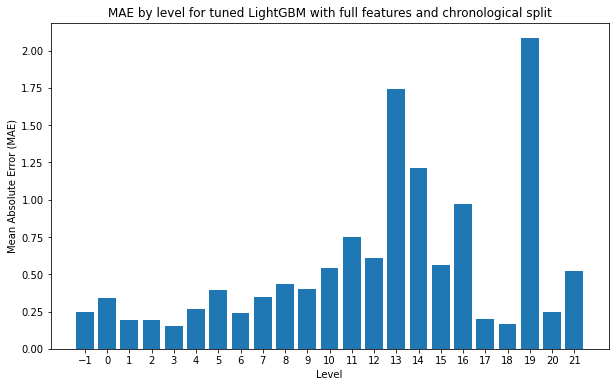

In [27]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for tuned LightGBM with full features and chronological split",
)

In [28]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Default:
MSE: 0.50
RMSE: 0.71

Round type: round
MSE: 0.56
RMSE: 0.75

Round type: 0.33
MSE: 0.50
RMSE: 0.70

Round type: 0.45
MSE: 0.54
RMSE: 0.73



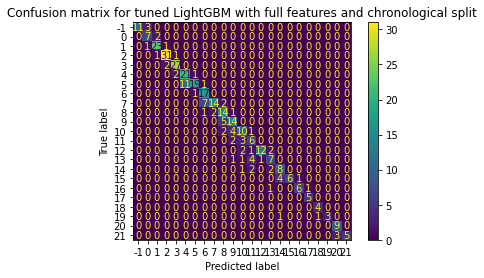

In [29]:
plot_confusion_matrix(
    "round",
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with full features and chronological split",
)

## Random split

In [30]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 804
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 48
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	valid_0's l1: 0.246737	valid_0's l2: 0.1379


In [31]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.14
RMSE: 0.37
MAE: 0.25


In [33]:
results.loc[2] = ["random", "default", "full", mse, rmse, mae]

###### MAE by level

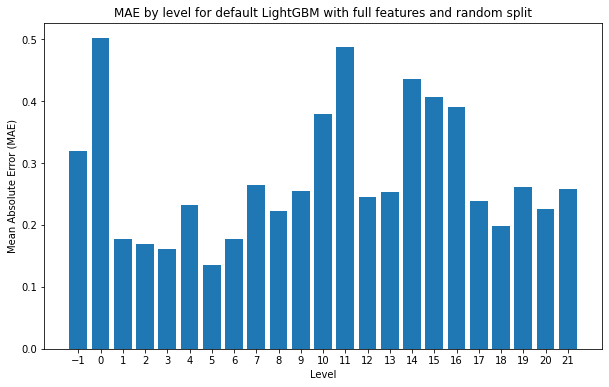

In [34]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for default LightGBM with full features and random split",
)

In [35]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Default:
MSE: 0.14
RMSE: 0.37

Round type: round
MSE: 0.14
RMSE: 0.38

Round type: 0.33
MSE: 0.19
RMSE: 0.43

Round type: 0.45
MSE: 0.15
RMSE: 0.38



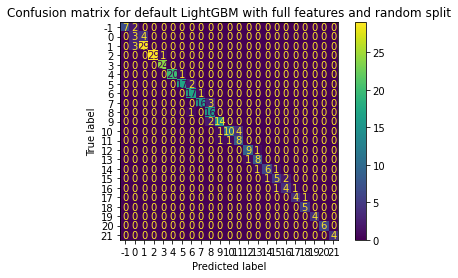

In [36]:
plot_confusion_matrix(
    "round",
    y_pred_test,
    y_test_random_split,
    title="Confusion matrix for default LightGBM with full features and random split",
)

### Tuning

In [37]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-05 12:03:26,490] A new study created in memory with name: no-name-bb8a6e0d-1475-4db3-9216-ef5795201d49
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.145545 + 0.0280298
[200]	cv_agg's l2: 0.141679 + 0.0269664
[300]	cv_agg's l2: 0.14066 + 0.0263995
[400]	cv_agg's l2: 0.139993 + 0.0257257
[500]	cv_agg's l2: 0.139732 + 0.0255354
[600]	cv_agg's l2: 0.139653 + 0.0253083
[700]	cv_agg's l2: 0.139567 + 0.0251451
Early stopping, best iteration is:
[631]	cv_agg's l2: 0.139539 + 0.0252567


feature_fraction, val_score: 0.139539:  14%|######4                                      | 1/7 [00:04<00:24,  4.11s/it]

[100]	cv_agg's l2: 0.16188 + 0.0462029
[200]	cv_agg's l2: 0.157371 + 0.0441822
[300]	cv_agg's l2: 0.156155 + 0.044525
[400]	cv_agg's l2: 0.155675 + 0.0439743
[500]	cv_agg's l2: 0.155222 + 0.0435148
[600]	cv_agg's l2: 0.155154 + 0.0433292


feature_fraction, val_score: 0.139539:  29%|############8                                | 2/7 [00:08<00:22,  4.54s/it]

[700]	cv_agg's l2: 0.154971 + 0.0430233
Early stopping, best iteration is:
[631]	cv_agg's l2: 0.139539 + 0.0252567
[100]	cv_agg's l2: 0.1745 + 0.0542813
[200]	cv_agg's l2: 0.170078 + 0.0514526
[300]	cv_agg's l2: 0.168684 + 0.0511311
[400]	cv_agg's l2: 0.167765 + 0.0501488
[500]	cv_agg's l2: 0.16745 + 0.0496344
[600]	cv_agg's l2: 0.167405 + 0.0493618


feature_fraction, val_score: 0.139539:  29%|############8                                | 2/7 [00:13<00:22,  4.54s/it]

[700]	cv_agg's l2: 0.167254 + 0.0491069
Early stopping, best iteration is:
[631]	cv_agg's l2: 0.139539 + 0.0252567


feature_fraction, val_score: 0.139539:  43%|###################2                         | 3/7 [00:13<00:18,  4.52s/it]

[100]	cv_agg's l2: 0.176141 + 0.0442915
[200]	cv_agg's l2: 0.17209 + 0.0423175
[300]	cv_agg's l2: 0.17129 + 0.0411383
[400]	cv_agg's l2: 0.170976 + 0.0403597
[500]	cv_agg's l2: 0.170833 + 0.0401118
[600]	cv_agg's l2: 0.170689 + 0.0397988
[700]	cv_agg's l2: 0.170657 + 0.0396887
Early stopping, best iteration is:
[631]	cv_agg's l2: 0.139539 + 0.0252567


feature_fraction, val_score: 0.139539:  57%|#########################7                   | 4/7 [00:17<00:13,  4.43s/it]

[100]	cv_agg's l2: 0.146564 + 0.0456485
[200]	cv_agg's l2: 0.143586 + 0.0453039
[300]	cv_agg's l2: 0.142727 + 0.0445926
[400]	cv_agg's l2: 0.142149 + 0.0443566
[500]	cv_agg's l2: 0.141923 + 0.0439685
[600]	cv_agg's l2: 0.141836 + 0.0437563


feature_fraction, val_score: 0.139539:  57%|#########################7                   | 4/7 [00:22<00:13,  4.43s/it]

[700]	cv_agg's l2: 0.141884 + 0.0437527
Early stopping, best iteration is:
[631]	cv_agg's l2: 0.139539 + 0.0252567


feature_fraction, val_score: 0.139539:  71%|################################1            | 5/7 [00:22<00:08,  4.37s/it]

[100]	cv_agg's l2: 0.168687 + 0.0517401
[200]	cv_agg's l2: 0.164334 + 0.050007
[300]	cv_agg's l2: 0.162951 + 0.0483883
[400]	cv_agg's l2: 0.16222 + 0.0477072
[500]	cv_agg's l2: 0.161974 + 0.0472285
[600]	cv_agg's l2: 0.161895 + 0.0470414


feature_fraction, val_score: 0.139539:  71%|################################1            | 5/7 [00:27<00:08,  4.37s/it]

[700]	cv_agg's l2: 0.161809 + 0.0468843
Early stopping, best iteration is:
[631]	cv_agg's l2: 0.139539 + 0.0252567


feature_fraction, val_score: 0.139539:  86%|######################################5      | 6/7 [00:27<00:04,  4.75s/it]

[100]	cv_agg's l2: 0.171774 + 0.0385179
[200]	cv_agg's l2: 0.168125 + 0.0370259
[300]	cv_agg's l2: 0.167077 + 0.0364716
[400]	cv_agg's l2: 0.166605 + 0.0362367
[500]	cv_agg's l2: 0.166486 + 0.0359509
[600]	cv_agg's l2: 0.166497 + 0.0358265


feature_fraction, val_score: 0.139539: 100%|#############################################| 7/7 [00:33<00:00,  4.72s/it]


[700]	cv_agg's l2: 0.166434 + 0.0357387
Early stopping, best iteration is:
[631]	cv_agg's l2: 0.139539 + 0.0252567


num_leaves, val_score: 0.139539:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.145545 + 0.0280298
[200]	cv_agg's l2: 0.141679 + 0.0269664
[300]	cv_agg's l2: 0.14066 + 0.0263995
[400]	cv_agg's l2: 0.139993 + 0.0257257
[500]	cv_agg's l2: 0.139732 + 0.0255354
[600]	cv_agg's l2: 0.139653 + 0.0253083


num_leaves, val_score: 0.139539:   0%|                                                          | 0/20 [00:05<?, ?it/s]

[700]	cv_agg's l2: 0.139567 + 0.0251451
Early stopping, best iteration is:
[631]	cv_agg's l2: 0.139539 + 0.0252567


num_leaves, val_score: 0.139539:   5%|##5                                               | 1/20 [00:05<01:35,  5.02s/it]

[100]	cv_agg's l2: 0.145545 + 0.0280298
[200]	cv_agg's l2: 0.141679 + 0.0269664
[300]	cv_agg's l2: 0.14066 + 0.0263995
[400]	cv_agg's l2: 0.139993 + 0.0257257
[500]	cv_agg's l2: 0.139732 + 0.0255354
[600]	cv_agg's l2: 0.139653 + 0.0253083


num_leaves, val_score: 0.139539:  10%|#####                                             | 2/20 [00:09<01:28,  4.91s/it]

[700]	cv_agg's l2: 0.139567 + 0.0251451
Early stopping, best iteration is:
[631]	cv_agg's l2: 0.139539 + 0.0252567
[100]	cv_agg's l2: 0.145545 + 0.0280298
[200]	cv_agg's l2: 0.141679 + 0.0269664
[300]	cv_agg's l2: 0.14066 + 0.0263995
[400]	cv_agg's l2: 0.139993 + 0.0257257
[500]	cv_agg's l2: 0.139732 + 0.0255354
[600]	cv_agg's l2: 0.139653 + 0.0253083


num_leaves, val_score: 0.139539:  10%|#####                                             | 2/20 [00:14<01:28,  4.91s/it]

[700]	cv_agg's l2: 0.139567 + 0.0251451
Early stopping, best iteration is:
[631]	cv_agg's l2: 0.139539 + 0.0252567


num_leaves, val_score: 0.139539:  15%|#######5                                          | 3/20 [00:14<01:18,  4.64s/it]

[100]	cv_agg's l2: 0.145545 + 0.0280298
[200]	cv_agg's l2: 0.141679 + 0.0269664
[300]	cv_agg's l2: 0.14066 + 0.0263995
[400]	cv_agg's l2: 0.139993 + 0.0257257
[500]	cv_agg's l2: 0.139732 + 0.0255354
[600]	cv_agg's l2: 0.139653 + 0.0253083
[700]	cv_agg's l2: 0.139567 + 0.0251451
Early stopping, best iteration is:
[631]	cv_agg's l2: 0.139539 + 0.0252567


num_leaves, val_score: 0.139539:  20%|##########                                        | 4/20 [00:18<01:13,  4.56s/it]

[100]	cv_agg's l2: 0.184757 + 0.0464612
[200]	cv_agg's l2: 0.162939 + 0.0435426
[300]	cv_agg's l2: 0.154768 + 0.041226
[400]	cv_agg's l2: 0.150426 + 0.0398007
[500]	cv_agg's l2: 0.14846 + 0.0397042
[600]	cv_agg's l2: 0.146737 + 0.0393633


num_leaves, val_score: 0.139539:  25%|############5                                     | 5/20 [00:20<00:53,  3.54s/it]

[700]	cv_agg's l2: 0.145298 + 0.0385202
Early stopping, best iteration is:
[631]	cv_agg's l2: 0.139539 + 0.0252567
[100]	cv_agg's l2: 0.145545 + 0.0280298
[200]	cv_agg's l2: 0.141679 + 0.0269664
[300]	cv_agg's l2: 0.14066 + 0.0263995
[400]	cv_agg's l2: 0.139993 + 0.0257257
[500]	cv_agg's l2: 0.139732 + 0.0255354
[600]	cv_agg's l2: 0.139653 + 0.0253083


num_leaves, val_score: 0.139539:  25%|############5                                     | 5/20 [00:24<00:53,  3.54s/it]

[700]	cv_agg's l2: 0.139567 + 0.0251451
Early stopping, best iteration is:
[631]	cv_agg's l2: 0.139539 + 0.0252567


num_leaves, val_score: 0.139539:  30%|###############                                   | 6/20 [00:24<00:52,  3.76s/it]

[100]	cv_agg's l2: 0.145545 + 0.0280298
[200]	cv_agg's l2: 0.141679 + 0.0269664
[300]	cv_agg's l2: 0.14066 + 0.0263995
[400]	cv_agg's l2: 0.139993 + 0.0257257
[500]	cv_agg's l2: 0.139732 + 0.0255354
[600]	cv_agg's l2: 0.139653 + 0.0253083
[700]	cv_agg's l2: 0.139567 + 0.0251451


num_leaves, val_score: 0.139539:  35%|#################5                                | 7/20 [00:29<00:52,  4.01s/it]

Early stopping, best iteration is:
[631]	cv_agg's l2: 0.139539 + 0.0252567
[100]	cv_agg's l2: 0.145545 + 0.0280298
[200]	cv_agg's l2: 0.141679 + 0.0269664
[300]	cv_agg's l2: 0.14066 + 0.0263995
[400]	cv_agg's l2: 0.139993 + 0.0257257
[500]	cv_agg's l2: 0.139732 + 0.0255354
[600]	cv_agg's l2: 0.139653 + 0.0253083


num_leaves, val_score: 0.139539:  40%|####################                              | 8/20 [00:33<00:48,  4.08s/it]

[700]	cv_agg's l2: 0.139567 + 0.0251451
Early stopping, best iteration is:
[631]	cv_agg's l2: 0.139539 + 0.0252567
[100]	cv_agg's l2: 0.145545 + 0.0280298
[200]	cv_agg's l2: 0.141679 + 0.0269664
[300]	cv_agg's l2: 0.14066 + 0.0263995
[400]	cv_agg's l2: 0.139993 + 0.0257257
[500]	cv_agg's l2: 0.139732 + 0.0255354
[600]	cv_agg's l2: 0.139653 + 0.0253083


num_leaves, val_score: 0.139539:  40%|####################                              | 8/20 [00:37<00:48,  4.08s/it]

[700]	cv_agg's l2: 0.139567 + 0.0251451
Early stopping, best iteration is:
[631]	cv_agg's l2: 0.139539 + 0.0252567


num_leaves, val_score: 0.139539:  45%|######################5                           | 9/20 [00:37<00:45,  4.16s/it]

[100]	cv_agg's l2: 0.145545 + 0.0280298
[200]	cv_agg's l2: 0.141679 + 0.0269664
[300]	cv_agg's l2: 0.14066 + 0.0263995
[400]	cv_agg's l2: 0.139993 + 0.0257257
[500]	cv_agg's l2: 0.139732 + 0.0255354
[600]	cv_agg's l2: 0.139653 + 0.0253083


num_leaves, val_score: 0.139539:  45%|######################5                           | 9/20 [00:41<00:45,  4.16s/it]

[700]	cv_agg's l2: 0.139567 + 0.0251451
Early stopping, best iteration is:
[631]	cv_agg's l2: 0.139539 + 0.0252567


num_leaves, val_score: 0.139539:  50%|########################5                        | 10/20 [00:41<00:41,  4.16s/it]

[100]	cv_agg's l2: 0.145545 + 0.0280298
[200]	cv_agg's l2: 0.141679 + 0.0269664
[300]	cv_agg's l2: 0.14066 + 0.0263995
[400]	cv_agg's l2: 0.139993 + 0.0257257
[500]	cv_agg's l2: 0.139732 + 0.0255354
[600]	cv_agg's l2: 0.139653 + 0.0253083
[700]	cv_agg's l2: 0.139567 + 0.0251451


num_leaves, val_score: 0.139539:  55%|##########################9                      | 11/20 [00:46<00:38,  4.29s/it]

Early stopping, best iteration is:
[631]	cv_agg's l2: 0.139539 + 0.0252567
[100]	cv_agg's l2: 0.145545 + 0.0280298
[200]	cv_agg's l2: 0.141679 + 0.0269664
[300]	cv_agg's l2: 0.14066 + 0.0263995
[400]	cv_agg's l2: 0.139993 + 0.0257257
[500]	cv_agg's l2: 0.139732 + 0.0255354
[600]	cv_agg's l2: 0.139653 + 0.0253083


num_leaves, val_score: 0.139539:  55%|##########################9                      | 11/20 [00:50<00:38,  4.29s/it]

[700]	cv_agg's l2: 0.139567 + 0.0251451
Early stopping, best iteration is:
[631]	cv_agg's l2: 0.139539 + 0.0252567


num_leaves, val_score: 0.139539:  60%|#############################4                   | 12/20 [00:50<00:34,  4.33s/it]

[100]	cv_agg's l2: 0.143573 + 0.0306494
[200]	cv_agg's l2: 0.140232 + 0.0285405
[300]	cv_agg's l2: 0.139153 + 0.0290154
[400]	cv_agg's l2: 0.139085 + 0.0285888


num_leaves, val_score: 0.138933:  65%|###############################8                 | 13/20 [00:52<00:25,  3.68s/it]

Early stopping, best iteration is:
[358]	cv_agg's l2: 0.138933 + 0.0286609
[100]	cv_agg's l2: 0.166648 + 0.0447427
[200]	cv_agg's l2: 0.152808 + 0.0411914
[300]	cv_agg's l2: 0.147381 + 0.039625


num_leaves, val_score: 0.138933:  70%|##################################3              | 14/20 [00:54<00:17,  2.94s/it]

[400]	cv_agg's l2: 0.144059 + 0.0386597
Early stopping, best iteration is:
[358]	cv_agg's l2: 0.138933 + 0.0286609
[100]	cv_agg's l2: 0.145545 + 0.0280298
[200]	cv_agg's l2: 0.141679 + 0.0269664
[300]	cv_agg's l2: 0.14066 + 0.0263995
[400]	cv_agg's l2: 0.139993 + 0.0257257


num_leaves, val_score: 0.138933:  75%|####################################7            | 15/20 [00:56<00:14,  2.88s/it]

Early stopping, best iteration is:
[358]	cv_agg's l2: 0.138933 + 0.0286609
[100]	cv_agg's l2: 0.145545 + 0.0280298
[200]	cv_agg's l2: 0.141679 + 0.0269664
[300]	cv_agg's l2: 0.14066 + 0.0263995
[400]	cv_agg's l2: 0.139993 + 0.0257257


num_leaves, val_score: 0.138933:  80%|#######################################2         | 16/20 [00:59<00:11,  2.80s/it]

Early stopping, best iteration is:
[358]	cv_agg's l2: 0.138933 + 0.0286609
[100]	cv_agg's l2: 0.145545 + 0.0280298
[200]	cv_agg's l2: 0.141679 + 0.0269664
[300]	cv_agg's l2: 0.14066 + 0.0263995
[400]	cv_agg's l2: 0.139993 + 0.0257257


num_leaves, val_score: 0.138933:  85%|#########################################6       | 17/20 [01:02<00:08,  2.75s/it]

Early stopping, best iteration is:
[358]	cv_agg's l2: 0.138933 + 0.0286609
[100]	cv_agg's l2: 0.143954 + 0.0285119
[200]	cv_agg's l2: 0.138923 + 0.0268256
[300]	cv_agg's l2: 0.137921 + 0.0260377
[400]	cv_agg's l2: 0.137386 + 0.0257616
[500]	cv_agg's l2: 0.137181 + 0.0253137


num_leaves, val_score: 0.137172:  90%|############################################1    | 18/20 [01:05<00:05,  2.86s/it]

Early stopping, best iteration is:
[449]	cv_agg's l2: 0.137172 + 0.025635
[100]	cv_agg's l2: 0.145725 + 0.0331423
[200]	cv_agg's l2: 0.142077 + 0.0317374
[300]	cv_agg's l2: 0.141462 + 0.0311311
[400]	cv_agg's l2: 0.141059 + 0.0305324
[500]	cv_agg's l2: 0.140998 + 0.030099


num_leaves, val_score: 0.137172:  95%|##############################################5  | 19/20 [01:08<00:02,  2.90s/it]

Early stopping, best iteration is:
[449]	cv_agg's l2: 0.137172 + 0.025635
[100]	cv_agg's l2: 0.145545 + 0.0280298
[200]	cv_agg's l2: 0.141679 + 0.0269664
[300]	cv_agg's l2: 0.14066 + 0.0263995
[400]	cv_agg's l2: 0.139993 + 0.0257257
[500]	cv_agg's l2: 0.139732 + 0.0255354


num_leaves, val_score: 0.137172: 100%|#################################################| 20/20 [01:11<00:00,  3.57s/it]


Early stopping, best iteration is:
[449]	cv_agg's l2: 0.137172 + 0.025635


bagging, val_score: 0.137172:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.14849 + 0.0209139
[200]	cv_agg's l2: 0.141831 + 0.0199688
[300]	cv_agg's l2: 0.140311 + 0.0197248
[400]	cv_agg's l2: 0.140142 + 0.0191507
[500]	cv_agg's l2: 0.139741 + 0.0190385


bagging, val_score: 0.137172:  10%|#####3                                               | 1/10 [00:02<00:26,  2.99s/it]

Early stopping, best iteration is:
[449]	cv_agg's l2: 0.137172 + 0.025635
[100]	cv_agg's l2: 0.203151 + 0.0306933
[200]	cv_agg's l2: 0.187774 + 0.0264743
[300]	cv_agg's l2: 0.184439 + 0.0256564
[400]	cv_agg's l2: 0.182265 + 0.0247035


bagging, val_score: 0.137172:  10%|#####3                                               | 1/10 [00:04<00:26,  2.99s/it]

[500]	cv_agg's l2: 0.180038 + 0.0241768
Early stopping, best iteration is:
[449]	cv_agg's l2: 0.137172 + 0.025635


bagging, val_score: 0.137172:  20%|##########6                                          | 2/10 [00:04<00:18,  2.36s/it]

[100]	cv_agg's l2: 0.145685 + 0.0294734
[200]	cv_agg's l2: 0.142409 + 0.0289446
[300]	cv_agg's l2: 0.141174 + 0.0279729
[400]	cv_agg's l2: 0.140935 + 0.0276948
[500]	cv_agg's l2: 0.140783 + 0.0274326


bagging, val_score: 0.137172:  30%|###############9                                     | 3/10 [00:08<00:19,  2.84s/it]

Early stopping, best iteration is:
[449]	cv_agg's l2: 0.137172 + 0.025635
[100]	cv_agg's l2: 0.161165 + 0.0199169
[200]	cv_agg's l2: 0.149274 + 0.0159591
[300]	cv_agg's l2: 0.145583 + 0.0140155
[400]	cv_agg's l2: 0.144529 + 0.0136867


bagging, val_score: 0.137172:  30%|###############9                                     | 3/10 [00:10<00:19,  2.84s/it]

[500]	cv_agg's l2: 0.14459 + 0.0129078
Early stopping, best iteration is:
[449]	cv_agg's l2: 0.137172 + 0.025635


bagging, val_score: 0.137172:  40%|#####################2                               | 4/10 [00:10<00:15,  2.62s/it]

[100]	cv_agg's l2: 0.157749 + 0.0295986
[200]	cv_agg's l2: 0.151793 + 0.0280489
[300]	cv_agg's l2: 0.150138 + 0.0308951
[400]	cv_agg's l2: 0.149411 + 0.0305408
[500]	cv_agg's l2: 0.148314 + 0.0302089


bagging, val_score: 0.137172:  50%|##########################5                          | 5/10 [00:13<00:12,  2.58s/it]

Early stopping, best iteration is:
[449]	cv_agg's l2: 0.137172 + 0.025635
[100]	cv_agg's l2: 0.205359 + 0.0241166
[200]	cv_agg's l2: 0.196424 + 0.0168688
[300]	cv_agg's l2: 0.19046 + 0.0156676
[400]	cv_agg's l2: 0.188326 + 0.0163947


bagging, val_score: 0.137172:  60%|###############################8                     | 6/10 [00:14<00:09,  2.30s/it]

[500]	cv_agg's l2: 0.187616 + 0.0170109
Early stopping, best iteration is:
[449]	cv_agg's l2: 0.137172 + 0.025635
[100]	cv_agg's l2: 0.141561 + 0.0310307
[200]	cv_agg's l2: 0.137279 + 0.0303619
[300]	cv_agg's l2: 0.13669 + 0.0301177
[400]	cv_agg's l2: 0.136127 + 0.0296996
[500]	cv_agg's l2: 0.13605 + 0.0291645
[600]	cv_agg's l2: 0.135752 + 0.028834


bagging, val_score: 0.135728:  70%|#####################################                | 7/10 [00:19<00:08,  2.97s/it]

[700]	cv_agg's l2: 0.135782 + 0.0286968
Early stopping, best iteration is:
[607]	cv_agg's l2: 0.135728 + 0.0288531
[100]	cv_agg's l2: 0.150623 + 0.0306436
[200]	cv_agg's l2: 0.145356 + 0.0287625
[300]	cv_agg's l2: 0.144356 + 0.0284532
[400]	cv_agg's l2: 0.143706 + 0.0278596
[500]	cv_agg's l2: 0.143509 + 0.0276205
[600]	cv_agg's l2: 0.143367 + 0.0273568


bagging, val_score: 0.135728:  80%|##########################################4          | 8/10 [00:23<00:06,  3.39s/it]

[700]	cv_agg's l2: 0.143234 + 0.0272192
Early stopping, best iteration is:
[607]	cv_agg's l2: 0.135728 + 0.0288531
[100]	cv_agg's l2: 0.149028 + 0.0238884
[200]	cv_agg's l2: 0.143797 + 0.022653
[300]	cv_agg's l2: 0.141284 + 0.0233115
[400]	cv_agg's l2: 0.140683 + 0.0234624
[500]	cv_agg's l2: 0.140471 + 0.0232384
[600]	cv_agg's l2: 0.140145 + 0.0230339


bagging, val_score: 0.135728:  90%|###############################################7     | 9/10 [00:27<00:03,  3.58s/it]

[700]	cv_agg's l2: 0.140232 + 0.0234373
Early stopping, best iteration is:
[607]	cv_agg's l2: 0.135728 + 0.0288531
[100]	cv_agg's l2: 0.145621 + 0.0238694
[200]	cv_agg's l2: 0.140477 + 0.0235815
[300]	cv_agg's l2: 0.139446 + 0.0239062
[400]	cv_agg's l2: 0.138264 + 0.0238015
[500]	cv_agg's l2: 0.137998 + 0.0237542
[600]	cv_agg's l2: 0.137697 + 0.0237172


bagging, val_score: 0.135728: 100%|####################################################| 10/10 [00:31<00:00,  3.17s/it]


[700]	cv_agg's l2: 0.137636 + 0.0234126
Early stopping, best iteration is:
[607]	cv_agg's l2: 0.135728 + 0.0288531


feature_fraction_stage2, val_score: 0.135728:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.145579 + 0.0325753
[200]	cv_agg's l2: 0.141679 + 0.0316059
[300]	cv_agg's l2: 0.140311 + 0.0315473
[400]	cv_agg's l2: 0.13947 + 0.0312202
[500]	cv_agg's l2: 0.13905 + 0.0307889
[600]	cv_agg's l2: 0.138757 + 0.0305256


feature_fraction_stage2, val_score: 0.135728:  33%|############6                         | 1/3 [00:04<00:08,  4.45s/it]

[700]	cv_agg's l2: 0.138676 + 0.0304581
Early stopping, best iteration is:
[607]	cv_agg's l2: 0.135728 + 0.0288531
[100]	cv_agg's l2: 0.147518 + 0.0284512
[200]	cv_agg's l2: 0.143366 + 0.0283154
[300]	cv_agg's l2: 0.142321 + 0.0286203
[400]	cv_agg's l2: 0.142041 + 0.0287185
[500]	cv_agg's l2: 0.141918 + 0.0289948
[600]	cv_agg's l2: 0.141721 + 0.0289204


feature_fraction_stage2, val_score: 0.135728:  67%|#########################3            | 2/3 [00:09<00:04,  4.53s/it]

[700]	cv_agg's l2: 0.141667 + 0.0289434
Early stopping, best iteration is:
[607]	cv_agg's l2: 0.135728 + 0.0288531
[100]	cv_agg's l2: 0.142647 + 0.0369684
[200]	cv_agg's l2: 0.139209 + 0.035822
[300]	cv_agg's l2: 0.138562 + 0.0356536
[400]	cv_agg's l2: 0.138193 + 0.0354715
[500]	cv_agg's l2: 0.137891 + 0.0352342
[600]	cv_agg's l2: 0.137672 + 0.0352199


feature_fraction_stage2, val_score: 0.135728: 100%|######################################| 3/3 [00:13<00:00,  4.59s/it]


[700]	cv_agg's l2: 0.137584 + 0.0351084
Early stopping, best iteration is:
[607]	cv_agg's l2: 0.135728 + 0.0288531


regularization_factors, val_score: 0.135728:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.145177 + 0.0324078
[200]	cv_agg's l2: 0.140996 + 0.0311248
[300]	cv_agg's l2: 0.139739 + 0.0305992
[400]	cv_agg's l2: 0.139217 + 0.0297129
[500]	cv_agg's l2: 0.139046 + 0.0293259
[600]	cv_agg's l2: 0.138921 + 0.0289812


regularization_factors, val_score: 0.135728:   5%|#9                                    | 1/20 [00:04<01:26,  4.58s/it]

[700]	cv_agg's l2: 0.138814 + 0.0286799
Early stopping, best iteration is:
[607]	cv_agg's l2: 0.135728 + 0.0288531
[100]	cv_agg's l2: 0.141561 + 0.0310307
[200]	cv_agg's l2: 0.137367 + 0.0302728
[300]	cv_agg's l2: 0.136611 + 0.0301972
[400]	cv_agg's l2: 0.135958 + 0.0298747
[500]	cv_agg's l2: 0.135887 + 0.0293361
[600]	cv_agg's l2: 0.135576 + 0.0290177


regularization_factors, val_score: 0.135547:  10%|###8                                  | 2/20 [00:09<01:24,  4.68s/it]

[700]	cv_agg's l2: 0.135627 + 0.0288577
Early stopping, best iteration is:
[607]	cv_agg's l2: 0.135547 + 0.0290374
[100]	cv_agg's l2: 0.141561 + 0.0310307
[200]	cv_agg's l2: 0.137279 + 0.0303619
[300]	cv_agg's l2: 0.13669 + 0.0301177
[400]	cv_agg's l2: 0.136127 + 0.0296996
[500]	cv_agg's l2: 0.13605 + 0.0291645
[600]	cv_agg's l2: 0.135752 + 0.028834


regularization_factors, val_score: 0.135547:  15%|#####7                                | 3/20 [00:14<01:20,  4.71s/it]

[700]	cv_agg's l2: 0.135782 + 0.0286967
Early stopping, best iteration is:
[607]	cv_agg's l2: 0.135547 + 0.0290374
[100]	cv_agg's l2: 0.141561 + 0.0310307
[200]	cv_agg's l2: 0.137279 + 0.0303619
[300]	cv_agg's l2: 0.13669 + 0.0301177
[400]	cv_agg's l2: 0.136127 + 0.0296996
[500]	cv_agg's l2: 0.13605 + 0.0291645
[600]	cv_agg's l2: 0.135752 + 0.028834


regularization_factors, val_score: 0.135547:  20%|#######6                              | 4/20 [00:19<01:17,  4.83s/it]

[700]	cv_agg's l2: 0.135782 + 0.0286967
Early stopping, best iteration is:
[607]	cv_agg's l2: 0.135547 + 0.0290374
[100]	cv_agg's l2: 0.141561 + 0.0310307
[200]	cv_agg's l2: 0.137279 + 0.0303619
[300]	cv_agg's l2: 0.13669 + 0.0301177
[400]	cv_agg's l2: 0.136127 + 0.0296996
[500]	cv_agg's l2: 0.13605 + 0.0291645
[600]	cv_agg's l2: 0.135752 + 0.028834


regularization_factors, val_score: 0.135547:  25%|#########5                            | 5/20 [00:23<01:12,  4.82s/it]

[700]	cv_agg's l2: 0.135782 + 0.0286967
Early stopping, best iteration is:
[607]	cv_agg's l2: 0.135547 + 0.0290374
[100]	cv_agg's l2: 0.141561 + 0.0310307
[200]	cv_agg's l2: 0.137279 + 0.0303619
[300]	cv_agg's l2: 0.13669 + 0.0301177
[400]	cv_agg's l2: 0.136127 + 0.0296996
[500]	cv_agg's l2: 0.13605 + 0.0291645
[600]	cv_agg's l2: 0.135752 + 0.028834


regularization_factors, val_score: 0.135547:  30%|###########4                          | 6/20 [00:28<01:06,  4.78s/it]

[700]	cv_agg's l2: 0.135782 + 0.0286967
Early stopping, best iteration is:
[607]	cv_agg's l2: 0.135547 + 0.0290374
[100]	cv_agg's l2: 0.141561 + 0.0310307
[200]	cv_agg's l2: 0.137279 + 0.0303619
[300]	cv_agg's l2: 0.13669 + 0.0301177
[400]	cv_agg's l2: 0.136127 + 0.0296996
[500]	cv_agg's l2: 0.13605 + 0.0291645
[600]	cv_agg's l2: 0.135752 + 0.028834


regularization_factors, val_score: 0.135547:  35%|#############3                        | 7/20 [00:33<01:02,  4.82s/it]

[700]	cv_agg's l2: 0.135782 + 0.0286967
Early stopping, best iteration is:
[607]	cv_agg's l2: 0.135547 + 0.0290374
[100]	cv_agg's l2: 0.141561 + 0.0310307
[200]	cv_agg's l2: 0.137279 + 0.0303619
[300]	cv_agg's l2: 0.13669 + 0.0301177
[400]	cv_agg's l2: 0.136127 + 0.0296996
[500]	cv_agg's l2: 0.13605 + 0.0291645
[600]	cv_agg's l2: 0.135752 + 0.028834


regularization_factors, val_score: 0.135547:  40%|###############2                      | 8/20 [00:38<00:57,  4.76s/it]

[700]	cv_agg's l2: 0.135782 + 0.0286967
Early stopping, best iteration is:
[607]	cv_agg's l2: 0.135547 + 0.0290374
[100]	cv_agg's l2: 0.141561 + 0.0310307
[200]	cv_agg's l2: 0.137279 + 0.0303619
[300]	cv_agg's l2: 0.13669 + 0.0301177
[400]	cv_agg's l2: 0.136127 + 0.0296996
[500]	cv_agg's l2: 0.13605 + 0.0291645
[600]	cv_agg's l2: 0.135752 + 0.028834


regularization_factors, val_score: 0.135547:  45%|#################1                    | 9/20 [00:42<00:52,  4.77s/it]

[700]	cv_agg's l2: 0.135782 + 0.0286967
Early stopping, best iteration is:
[607]	cv_agg's l2: 0.135547 + 0.0290374
[100]	cv_agg's l2: 0.141561 + 0.0310307
[200]	cv_agg's l2: 0.137279 + 0.0303619
[300]	cv_agg's l2: 0.13669 + 0.0301177
[400]	cv_agg's l2: 0.136127 + 0.0296996
[500]	cv_agg's l2: 0.13605 + 0.0291645
[600]	cv_agg's l2: 0.135752 + 0.028834


regularization_factors, val_score: 0.135547:  50%|##################5                  | 10/20 [00:47<00:48,  4.80s/it]

[700]	cv_agg's l2: 0.135782 + 0.0286967
Early stopping, best iteration is:
[607]	cv_agg's l2: 0.135547 + 0.0290374
[100]	cv_agg's l2: 0.141561 + 0.0310307
[200]	cv_agg's l2: 0.137367 + 0.0302728
[300]	cv_agg's l2: 0.136611 + 0.0301972
[400]	cv_agg's l2: 0.135958 + 0.0298747
[500]	cv_agg's l2: 0.135887 + 0.0293361
[600]	cv_agg's l2: 0.135576 + 0.0290177


regularization_factors, val_score: 0.135547:  55%|####################3                | 11/20 [00:52<00:42,  4.78s/it]

[700]	cv_agg's l2: 0.135604 + 0.0288827
Early stopping, best iteration is:
[607]	cv_agg's l2: 0.135547 + 0.0290374
[100]	cv_agg's l2: 0.141561 + 0.0310307
[200]	cv_agg's l2: 0.137279 + 0.0303619
[300]	cv_agg's l2: 0.13669 + 0.0301177
[400]	cv_agg's l2: 0.136127 + 0.0296996
[500]	cv_agg's l2: 0.13605 + 0.0291645
[600]	cv_agg's l2: 0.135748 + 0.0288362


regularization_factors, val_score: 0.135547:  60%|######################2              | 12/20 [00:57<00:38,  4.77s/it]

[700]	cv_agg's l2: 0.135775 + 0.0287004
Early stopping, best iteration is:
[607]	cv_agg's l2: 0.135547 + 0.0290374
[100]	cv_agg's l2: 0.141561 + 0.0310307
[200]	cv_agg's l2: 0.137367 + 0.0302728
[300]	cv_agg's l2: 0.136611 + 0.0301972
[400]	cv_agg's l2: 0.135958 + 0.0298747
[500]	cv_agg's l2: 0.135887 + 0.0293361
[600]	cv_agg's l2: 0.135576 + 0.0290177


regularization_factors, val_score: 0.135547:  65%|########################             | 13/20 [01:02<00:34,  4.86s/it]

[700]	cv_agg's l2: 0.135595 + 0.0289086
Early stopping, best iteration is:
[607]	cv_agg's l2: 0.135547 + 0.0290374
[100]	cv_agg's l2: 0.141561 + 0.0310307
[200]	cv_agg's l2: 0.137367 + 0.0302728
[300]	cv_agg's l2: 0.136611 + 0.0301972
[400]	cv_agg's l2: 0.135958 + 0.0298747
[500]	cv_agg's l2: 0.135887 + 0.0293361
[600]	cv_agg's l2: 0.135656 + 0.0291445


regularization_factors, val_score: 0.135547:  70%|#########################9           | 14/20 [01:07<00:29,  4.84s/it]

[700]	cv_agg's l2: 0.135609 + 0.028944
Early stopping, best iteration is:
[607]	cv_agg's l2: 0.135547 + 0.0290374
[100]	cv_agg's l2: 0.141561 + 0.0310307
[200]	cv_agg's l2: 0.137367 + 0.0302728
[300]	cv_agg's l2: 0.136611 + 0.0301972
[400]	cv_agg's l2: 0.135958 + 0.0298747
[500]	cv_agg's l2: 0.135887 + 0.0293361
[600]	cv_agg's l2: 0.135656 + 0.0291445


regularization_factors, val_score: 0.135547:  75%|###########################7         | 15/20 [01:11<00:24,  4.85s/it]

[700]	cv_agg's l2: 0.135609 + 0.028944
Early stopping, best iteration is:
[607]	cv_agg's l2: 0.135547 + 0.0290374
[100]	cv_agg's l2: 0.141561 + 0.0310307
[200]	cv_agg's l2: 0.137367 + 0.0302728
[300]	cv_agg's l2: 0.136611 + 0.0301972
[400]	cv_agg's l2: 0.135958 + 0.0298747
[500]	cv_agg's l2: 0.135883 + 0.0293296
[600]	cv_agg's l2: 0.135611 + 0.0290092
[700]	cv_agg's l2: 0.135516 + 0.0287395


regularization_factors, val_score: 0.135488:  80%|#############################6       | 16/20 [01:17<00:20,  5.00s/it]

[800]	cv_agg's l2: 0.135507 + 0.0286221
Early stopping, best iteration is:
[722]	cv_agg's l2: 0.135488 + 0.0287183
[100]	cv_agg's l2: 0.141561 + 0.0310307
[200]	cv_agg's l2: 0.137367 + 0.0302728
[300]	cv_agg's l2: 0.136611 + 0.0301972
[400]	cv_agg's l2: 0.136035 + 0.0297946
[500]	cv_agg's l2: 0.135902 + 0.0293098
[600]	cv_agg's l2: 0.135619 + 0.029
[700]	cv_agg's l2: 0.135551 + 0.0287021


regularization_factors, val_score: 0.135488:  85%|###############################4     | 17/20 [01:23<00:15,  5.21s/it]

[800]	cv_agg's l2: 0.135541 + 0.028597
Early stopping, best iteration is:
[722]	cv_agg's l2: 0.135488 + 0.0287183
[100]	cv_agg's l2: 0.141561 + 0.0310307
[200]	cv_agg's l2: 0.137367 + 0.0302728
[300]	cv_agg's l2: 0.136611 + 0.0301972
[400]	cv_agg's l2: 0.135958 + 0.0298747
[500]	cv_agg's l2: 0.135883 + 0.0293296
[600]	cv_agg's l2: 0.135611 + 0.0290092
[700]	cv_agg's l2: 0.135516 + 0.0287395


regularization_factors, val_score: 0.135488:  90%|#################################3   | 18/20 [01:28<00:10,  5.30s/it]

[800]	cv_agg's l2: 0.135507 + 0.028622
Early stopping, best iteration is:
[722]	cv_agg's l2: 0.135488 + 0.0287183
[100]	cv_agg's l2: 0.141561 + 0.0310307
[200]	cv_agg's l2: 0.137367 + 0.0302728
[300]	cv_agg's l2: 0.136611 + 0.0301972
[400]	cv_agg's l2: 0.135958 + 0.0298747
[500]	cv_agg's l2: 0.135883 + 0.0293296
[600]	cv_agg's l2: 0.135611 + 0.0290092
[700]	cv_agg's l2: 0.135516 + 0.0287395


regularization_factors, val_score: 0.135488:  90%|#################################3   | 18/20 [01:34<00:10,  5.30s/it]

[800]	cv_agg's l2: 0.135507 + 0.028622
Early stopping, best iteration is:
[722]	cv_agg's l2: 0.135488 + 0.0287183


regularization_factors, val_score: 0.135488:  95%|###################################1 | 19/20 [01:34<00:05,  5.36s/it]

[100]	cv_agg's l2: 0.141561 + 0.0310307
[200]	cv_agg's l2: 0.137367 + 0.0302728
[300]	cv_agg's l2: 0.136611 + 0.0301972
[400]	cv_agg's l2: 0.136035 + 0.0297946
[500]	cv_agg's l2: 0.135902 + 0.0293098
[600]	cv_agg's l2: 0.135619 + 0.029
[700]	cv_agg's l2: 0.135551 + 0.0287021


regularization_factors, val_score: 0.135488: 100%|#####################################| 20/20 [01:39<00:00,  4.97s/it]


[800]	cv_agg's l2: 0.135521 + 0.0286088
Early stopping, best iteration is:
[722]	cv_agg's l2: 0.135488 + 0.0287183


min_data_in_leaf, val_score: 0.135488:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.143631 + 0.0335109
[200]	cv_agg's l2: 0.142065 + 0.0338619
[300]	cv_agg's l2: 0.14195 + 0.0337666
[400]	cv_agg's l2: 0.141832 + 0.0336811
[500]	cv_agg's l2: 0.141812 + 0.0337145
[600]	cv_agg's l2: 0.141808 + 0.0337292
[700]	cv_agg's l2: 0.141804 + 0.0337408


min_data_in_leaf, val_score: 0.135488:  20%|#########                                    | 1/5 [00:06<00:24,  6.18s/it]

[800]	cv_agg's l2: 0.141807 + 0.0337444
Early stopping, best iteration is:
[722]	cv_agg's l2: 0.135488 + 0.0287183
[100]	cv_agg's l2: 0.145762 + 0.0256918
[200]	cv_agg's l2: 0.142782 + 0.0248962
[300]	cv_agg's l2: 0.14212 + 0.0243932
[400]	cv_agg's l2: 0.142022 + 0.0240835
[500]	cv_agg's l2: 0.141923 + 0.0239879
[600]	cv_agg's l2: 0.141926 + 0.0239634
[700]	cv_agg's l2: 0.141931 + 0.0239486


min_data_in_leaf, val_score: 0.135488:  20%|#########                                    | 1/5 [00:12<00:24,  6.18s/it]

[800]	cv_agg's l2: 0.141913 + 0.023898
Early stopping, best iteration is:
[722]	cv_agg's l2: 0.135488 + 0.0287183


min_data_in_leaf, val_score: 0.135488:  40%|##################                           | 2/5 [00:12<00:18,  6.29s/it]

[100]	cv_agg's l2: 0.151123 + 0.0303637
[200]	cv_agg's l2: 0.147292 + 0.0305147
[300]	cv_agg's l2: 0.146301 + 0.0304668
[400]	cv_agg's l2: 0.146255 + 0.0300595
[500]	cv_agg's l2: 0.145955 + 0.029736
[600]	cv_agg's l2: 0.145633 + 0.0296065
[700]	cv_agg's l2: 0.145609 + 0.0296788


min_data_in_leaf, val_score: 0.135488:  60%|###########################                  | 3/5 [00:17<00:11,  5.65s/it]

[800]	cv_agg's l2: 0.145485 + 0.0295765
Early stopping, best iteration is:
[722]	cv_agg's l2: 0.135488 + 0.0287183
[100]	cv_agg's l2: 0.217348 + 0.0310497
[200]	cv_agg's l2: 0.206938 + 0.0291302
[300]	cv_agg's l2: 0.20444 + 0.0272988
[400]	cv_agg's l2: 0.205716 + 0.0267929
[500]	cv_agg's l2: 0.205933 + 0.025508
[600]	cv_agg's l2: 0.206764 + 0.0254353
[700]	cv_agg's l2: 0.207976 + 0.0253455


min_data_in_leaf, val_score: 0.135488:  80%|####################################         | 4/5 [00:20<00:04,  4.71s/it]

[800]	cv_agg's l2: 0.209461 + 0.0244387
Early stopping, best iteration is:
[722]	cv_agg's l2: 0.135488 + 0.0287183
[100]	cv_agg's l2: 0.679344 + 0.0670008
[200]	cv_agg's l2: 0.641945 + 0.0572827
[300]	cv_agg's l2: 0.621246 + 0.0577201
[400]	cv_agg's l2: 0.609215 + 0.0597934
[500]	cv_agg's l2: 0.601496 + 0.0636309
[600]	cv_agg's l2: 0.595834 + 0.0639466
[700]	cv_agg's l2: 0.592501 + 0.0636156


min_data_in_leaf, val_score: 0.135488: 100%|#############################################| 5/5 [00:23<00:00,  4.61s/it]

[800]	cv_agg's l2: 0.589872 + 0.062542
Early stopping, best iteration is:
[722]	cv_agg's l2: 0.135488 + 0.0287183


In [38]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.1354883198377519
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 1.6140216912147042e-06
    lambda_l2: 1.4746814861620986e-06
    num_leaves: 29
    feature_fraction: 0.4
    bagging_fraction: 0.9951495103940697
    bagging_freq: 3
    min_child_samples: 20


In [39]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [40]:
rmse, mse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.33
MSE test: 0.11
MAE test: 0.23



In [41]:
results.loc[3] = ["random", "Optuna", "full", mse, rmse, mae]

###### MAE by level

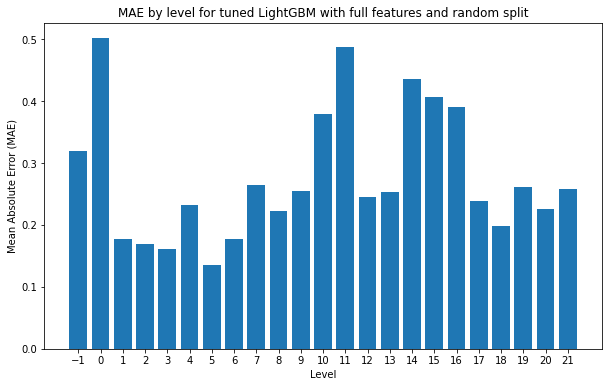

In [42]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for tuned LightGBM with full features and random split",
)

In [43]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Default:
MSE: 0.04
RMSE: 0.20

Round type: round
MSE: 0.05
RMSE: 0.22

Round type: 0.33
MSE: 0.06
RMSE: 0.25

Round type: 0.45
MSE: 0.05
RMSE: 0.22



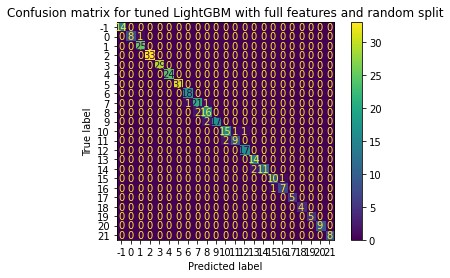

In [44]:
plot_confusion_matrix(
    "round",
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with full features and random split",
)

## Summary

In [45]:
results

,Split type,Tuning type,Set of features,MSE,RMSE,MAE
0,chronological,default,full,0.932502,0.965662,0.463517
1,chronological,Optuna,full,0.497044,0.705013,0.407766
2,random,default,full,0.137900,0.371349,0.246737
3,random,Optuna,full,0.106014,0.325597,0.227292


In [46]:
from training.results import plot_summary

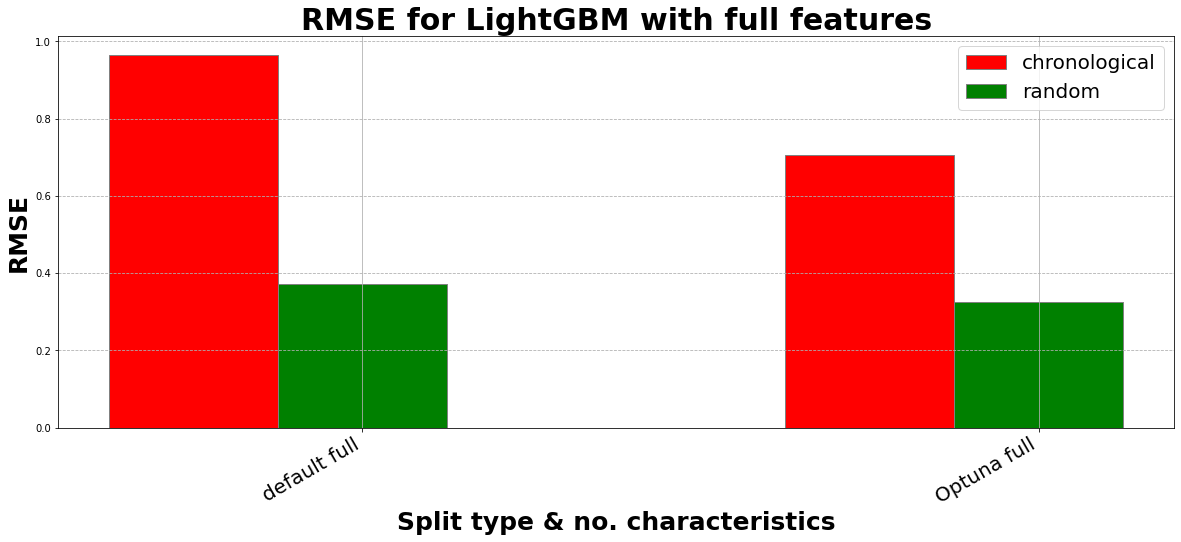

In [47]:
plot_summary(results, "RMSE", title="RMSE for LightGBM with full features")

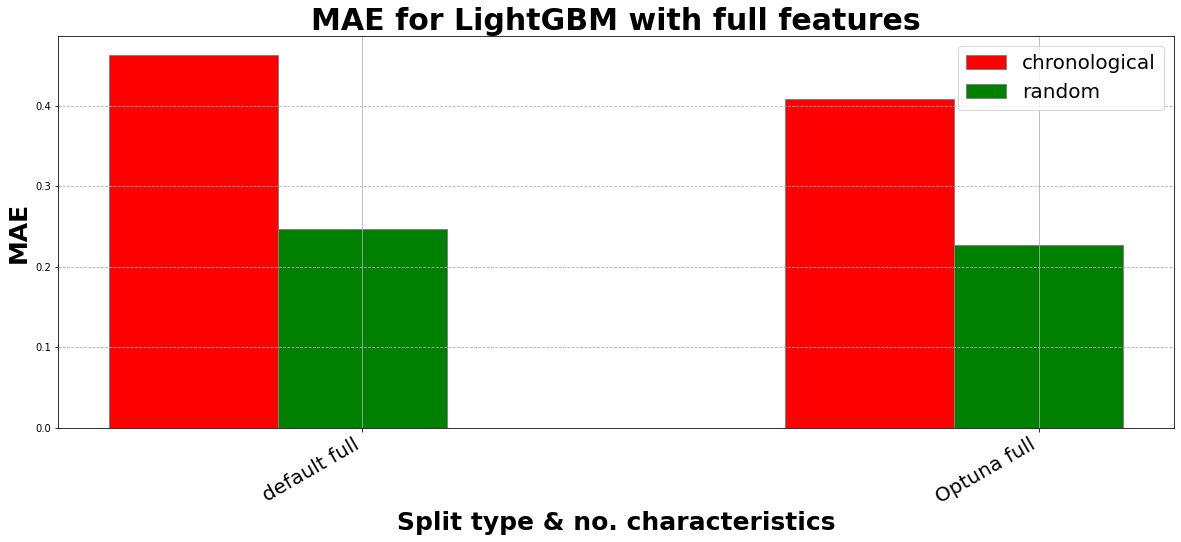

In [48]:
plot_summary(results, "MAE", title="MAE for LightGBM with full features")

In [49]:
results.to_json("./lightgbm_full_results.json", indent=2)